In [1]:
# As usual, a bit of setup

import time, os, json
import numpy as np
import skimage.io
import matplotlib.pyplot as plt

from cs231n.classifiers.pretrained_cnn import PretrainedCNN
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import blur_image, deprocess_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
data = load_tiny_imagenet('cs231n/datasets/tiny-imagenet-100-A', subtract_mean=True)
# The images are zero-centered by the setting subtract_mean=True.

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


In [3]:
model = PretrainedCNN(h5_file='cs231n/datasets/pretrained_model.h5')

# Extra: Class Model Visualization (look @ Q4)
As described in Section 2 of [1], we could numerically generate an image which maximize the class score. (Without implicit regularizer)

[1] Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman. "Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps", ICLR Workshop 2014.

[2] Yosinski et al, "Understanding Neural Networks Through Deep Visualization", ICML 2015 Deep Learning Workshop

In [36]:
from cs231n.optim import *
# from cs231n.layers import *

# settings
mask = np.random.randint(data['X_val'].shape[0], size=5)
y = np.unique(data['y_val'][mask])
config={'learning_rate': 5}  # 1e5 
reg = 1e-6  # 1e-6
num_iter = 100

# initialize image
C = len(y)  # number of class
print 'number of classes:', C
_, c, w, h = data['X_val'].shape
X = np.random.randn(C, c, w, h)

# training on X
loss_history = {y[j]: [] for j in range(C)}
for i in xrange(num_iter):
    scores, cache = model.forward(X, mode='test')  
    loss = scores[range(C), y] - reg * np.sum(X * X, axis=(1, 2, 3))  # to maximize the loss
    loss = -loss  # to minimize the loss
    dscores = np.zeros_like(scores)
    dscores[range(C), y] = -1  # '1' for gradient ascent, '-1' for gradient descent
    dX, _ = model.backward(dscores, cache) 
    dX += 2 * reg * X  # '-=' for gradient ascent; '+=' for gradient descent
#     X -= config['learning_rate'] * dX  # '+=' for gradient ascent; '-=' for gradient descent
    X, config = adam(X, dX, config)  # gradient descent using Adam
    
    for j in range(C):
        loss_history[y[j]].append(loss[j])
        
    if i % 10 == 0:
        print 'iter =', i, '/', num_iter, ', loss =', np.around(loss, decimals=2)

number of classes: 5
iter = 0 / 100 , loss = [-0.74 -2.01 -0.25  1.87  0.36]
iter = 10 / 100 , loss = [-18.   -16.61 -11.86 -23.91 -21.68]
iter = 20 / 100 , loss = [-27.04 -30.88 -22.45 -45.54 -56.58]
iter = 30 / 100 , loss = [-32.65 -40.41 -32.9  -60.86 -77.78]
iter = 40 / 100 , loss = [-37.09 -45.76 -42.22 -70.71 -88.55]
iter = 50 / 100 , loss = [-40.08 -49.5  -49.46 -77.63 -96.48]
iter = 60 / 100 , loss = [ -42.47  -52.34  -56.2   -81.86 -101.29]
iter = 70 / 100 , loss = [ -44.55  -54.49  -60.54  -84.72 -104.52]
iter = 80 / 100 , loss = [ -46.55  -56.29  -63.44  -87.02 -106.87]
iter = 90 / 100 , loss = [ -48.01  -58.01  -65.41  -88.78 -108.42]


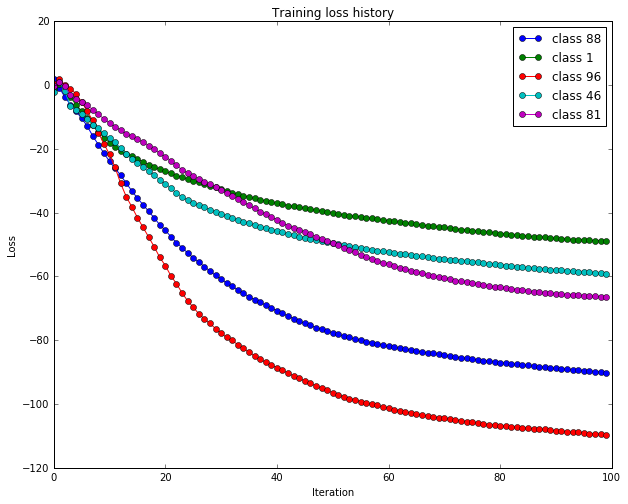

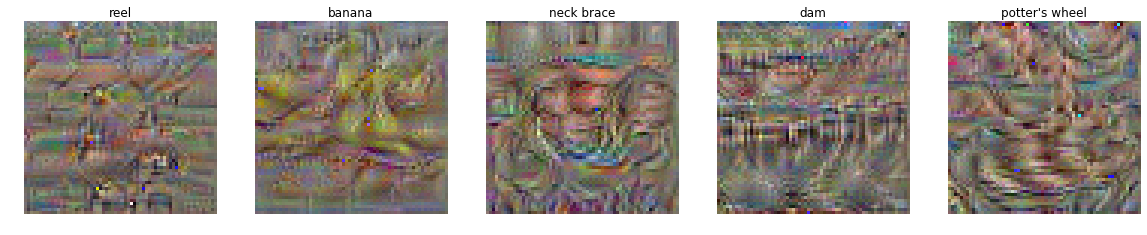

In [37]:
# Plot the training losses
for key, value in loss_history.iteritems():
    plt.plot(loss_history[key], '-o', label='class %d' % key)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.legend(loc='upper right')
plt.show()

# plot the image 
for i in range(C):
    plt.subplot(1, C, i + 1)
    plt.imshow(deprocess_image(X[i], data['mean_image'], mean='image', renorm=False))
    plt.gcf().set_size_inches(20, 20)
    plt.axis('off')
    plt.title(data['class_names'][y[i]][0])
plt.show()

Maximize the class score is equivalent to minimize all the other class scores:

In [38]:
from cs231n.optim import *
# from cs231n.layers import *

# settings
mask = np.random.randint(data['X_val'].shape[0], size=5)
y = np.unique(data['y_val'][mask])
config={'learning_rate': 5}  # 1e5 
reg = 1e-6  # 1e-6
num_iter = 100

# initialize image
C = len(y)  # number of class
print 'number of classes:', C
_, c, w, h = data['X_val'].shape
X = np.random.randn(C, c, w, h)

# training on X
loss_history = {y[j]: [] for j in range(C)}
for i in xrange(num_iter):
    scores, cache = model.forward(X, mode='test')
    loss = scores[range(C), y] - reg * np.sum(X * X, axis=(1, 2, 3))
    loss = -loss  
    dscores = np.ones_like(scores)
    dscores[range(C), y] = 0  # note that this is minimizing all the other class scores
    dX, _ = model.backward(dscores, cache) 
    dX += 2 * reg * X  
    X, config = adam(X, dX, config)  
    
    for j in range(C):
        loss_history[y[j]].append(loss[j])
        
    if i % 10 == 0:
        print 'iter =', i, '/', num_iter, ', loss =', np.around(loss, decimals=2)

number of classes: 5
iter = 0 / 100 , loss = [-0.34  0.38 -4.17  1.46  0.35]
iter = 10 / 100 , loss = [-24.87 -18.26 -29.13 -32.98 -32.74]
iter = 20 / 100 , loss = [-37.77 -27.31 -45.55 -42.78 -64.05]
iter = 30 / 100 , loss = [-46.64 -35.   -54.71 -49.82 -79.34]
iter = 40 / 100 , loss = [-52.56 -43.4  -60.44 -54.83 -89.45]
iter = 50 / 100 , loss = [-56.9  -50.21 -64.85 -57.97 -95.96]
iter = 60 / 100 , loss = [ -60.01  -56.31  -68.13  -60.23 -100.24]
iter = 70 / 100 , loss = [ -62.08  -60.52  -70.58  -61.74 -103.08]
iter = 80 / 100 , loss = [ -63.66  -63.37  -72.71  -63.   -104.99]
iter = 90 / 100 , loss = [ -65.3   -65.51  -74.38  -64.07 -106.43]


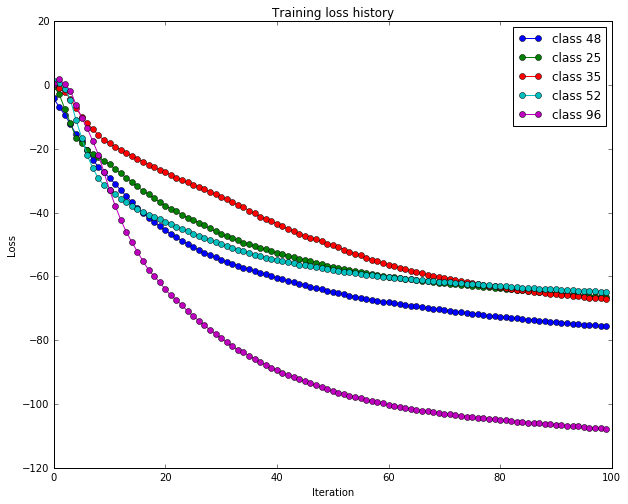

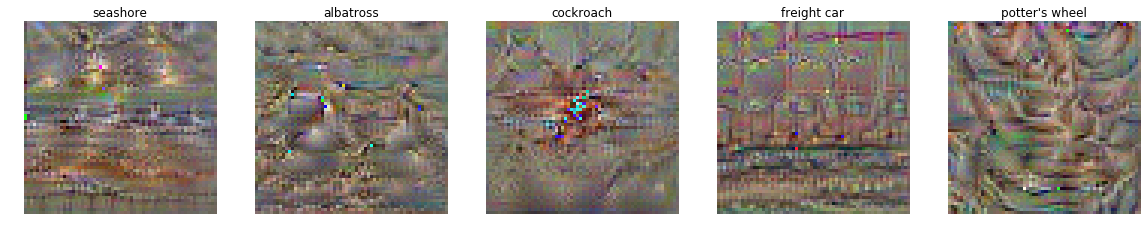

In [39]:
# Plot the training losses
for key, value in loss_history.iteritems():
    plt.plot(loss_history[key], '-o', label='class %d' % key)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Training loss history')
plt.legend(loc='upper right')
plt.show()

# plot the image 
for i in range(C):
    plt.subplot(1, C, i + 1)
    plt.imshow(deprocess_image(X[i], data['mean_image'], mean='image', renorm=False))
    plt.gcf().set_size_inches(20, 20)
    plt.axis('off')
    plt.title(data['class_names'][y[i]][0])
plt.show()

# Conclusion

The result generated by gradient descent looks quite similar to the ones in Q4. 

Note: Adding implicit regularizer as described in [2] (4 kinds of regularizer listed) would definitely reduce the artifact.